### #2. Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**1) 데이터 불러오기**

In [2]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

**2) 모델 클래스 생성**

In [17]:
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = err
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2* np.sum(self.w ** 2)
    
    def update_val_loss(self, x_val, y_val):
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1 - 1e-10)
            val_loss += -(y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))
        self.val_losses.append(val_loss / len(y_val) + self.reg_loss())
        
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def fit(self, x, y, x_val=None, y_val=None, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            
            for k in indexes:
                z = self.forpass(x[k])
                a = self.activation(z)
                err = -(y[k] - a)
                w_grad, b_grad = self.backprop(x[k], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= self.lr * b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1 - 1e-10)
                loss += -(y[k] * np.log(a) + (1 - y[k]) * np.log(1 - a))
                
            self.losses.append(loss / len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)

**3) 훈련 데이터와 검증 데이터로 분할**

In [4]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, random_state=42
)

**4) 모델 훈련**

In [18]:
single_layer = SingleLayer()
single_layer.fit(X_train, y_train, X_val, y_val)

C:\Users\lg\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


In [21]:
print('검증 데이터 성능 정확도: {:.2f}'.format(single_layer.score(X_val, y_val)))

검증 데이터 성능 정확도: 0.95


**5) 가중치 그래프**

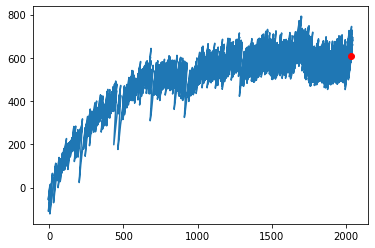

In [22]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.show()

**6) 손실 그래프**

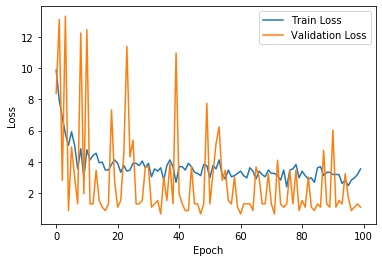

In [23]:
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

**7) 스케일 조정후 모델 훈련**

In [24]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
X_train_scaled = (X_train - train_mean) / train_std

val_mean = np.mean(X_val, axis=0)
val_std = np.std(X_val, axis=0)
X_val_scaled = (X_val - val_mean) / val_std

In [25]:
single_layer = SingleLayer()
single_layer.fit(X_train_scaled, y_train, X_val_scaled, y_val)

In [28]:
print('훈련 데이터 성능 정확도: {:.2f}'.format(single_layer.score(X_train_scaled, y_train)))
print('검증 데이터 성능 정확도: {:.2f}'.format(single_layer.score(X_val_scaled, y_val)))

훈련 데이터 성능 정확도: 0.99
검증 데이터 성능 정확도: 0.97


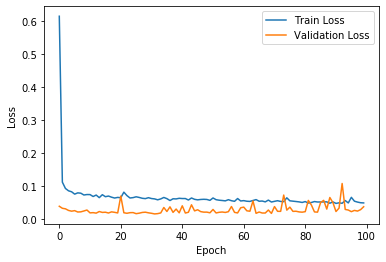

In [27]:
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

**8) 교차 검증**

In [29]:
k = 10
bins = len(X_train) // k
validation_scores = []

for i in range(k):
    start = bins * i
    end = bins * (i + 1)
    val_fold = X_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(start)) + list(range(end, len(X_train)))
    train_fold = X_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    single_layer = SingleLayer()
    single_layer.fit(train_fold_scaled, train_target, val_fold_scaled, val_target)
    validation_scores.append(single_layer.score(val_fold_scaled, val_target))
    
print('교차 검증후 검증 데이터 성능 정확도: {:.2f}'.format(np.mean(validation_scores)))

교차 검증후 검증 데이터 성능 정확도: 0.95


**9) 사이킷런을 통한 교차 검증**

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, X_train, y_train, cv=10)
print('사이킷런을 통한 교차 검증 정확도: {:.2f}'.format(np.mean(scores['test_score'])))

사이킷런을 통한 교차 검증 정확도: 0.97
